In [191]:
import numpy as np
import pandas as pd
import scipy.stats as stat
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed

# TP2 Simulation d'actifs financiers.

# Exercice 1

En $t=0$ le prix de l'option est $$e^{-rT}\mathbb{E}\left[\left( S_T - K \right)^+\right]$$.

Et la dynamique de $(S_t)_t$ est donnée par $$dS_t=rS_t\operatorname{d}t\, + \sigma S_t\operatorname{d}W_t$$

Et on peut discrétiser (Euler-Maruyama) : 

\begin{equation*}
S_{t_{i+1}} = S_{t_i}\left[ 1 + rh + \sqrt{h}\sigma Z \right]
\end{equation*}

Avec $Z\sim\mathcal{N}(0, 1)$ et $h=t_{i+1}-t_{i}$

In [126]:
N, n, K, S_0, r, sigma, mu, T = 100, 1000, 800, 1000, 0.05, 0.2, 0.1, 1

In [127]:
def C_mc(N=N, n=n, K=K, S_0=S_0, r=r, sigma=sigma, mu=mu, T=T):

    S = np.full(n, S_0)
    h = T/N

    for i in range(N):
        Z = np.random.normal(0, 1, n)
        S = S * (r * h + np.sqrt(h) * sigma * Z + 1)

    pay_off = np.maximum(S - K, 0) 

    C = np.exp(-r * T) * np.mean( pay_off )

    return C, 2 * 1.96 * np.std(pay_off)/np.sqrt(n) #Donne la taille de l'intervalle de confiance


In [128]:
conf_mc = np.zeros(11)
C_estime = np.zeros(11)

In [129]:
C_estime, conf_mc = zip(*[C_mc(N=i) for i in tqdm(range(100, 10_000, 100))])

100%|██████████| 99/99 [00:18<00:00,  5.25it/s]


In [130]:
print(np.var(C_estime), np.mean(conf_mc))

35.76696203011803 24.886643100763216


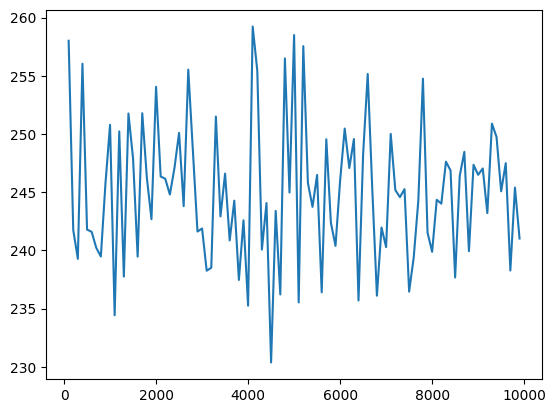

In [131]:
plt.plot(range(100, 10_000, 100), C_estime)
plt.show()

Le schéma de Milstein donne :

\begin{equation*}
S_{h(j+1)}=S_{hj}\left[1 +h \left(\operatorname{drift} + \frac12 \sigma^2 (Z^2-1)\right)+\sqrt{h}\sigma Z\right]
\end{equation*}

In [132]:
def C_mc_mil(N=N, n=n, K=K, S_0=S_0, r=r, sigma=sigma, mu=mu, T=T):
    S = np.full(n, S_0)
    h = T/N

    for i in range(N):
        Z = np.random.normal(0, 1, n)
        S = S * (1 + h * (r + 0.5 * sigma**2 * (Z ** 2 - 1)) + np.sqrt(h) * sigma * Z)

    pay_off = np.maximum(S - K, 0) 
    C = np.exp(-r * T) * np.mean( pay_off )

    return C, 2 * 1.96 * np.std(pay_off)/np.sqrt(n)

In [133]:
conf_mc_mil = np.zeros(11)
C_estime_mil = np.zeros(11)

In [134]:
C_estime_mil, conf_mc_mil = zip(*[C_mc_mil(N=i) for i in tqdm(range(100, 10_000, 100))])

100%|██████████| 99/99 [00:21<00:00,  4.71it/s]


In [135]:
print(np.var(C_estime_mil), np.mean(conf_mc))

38.80280658493954 24.886643100763216


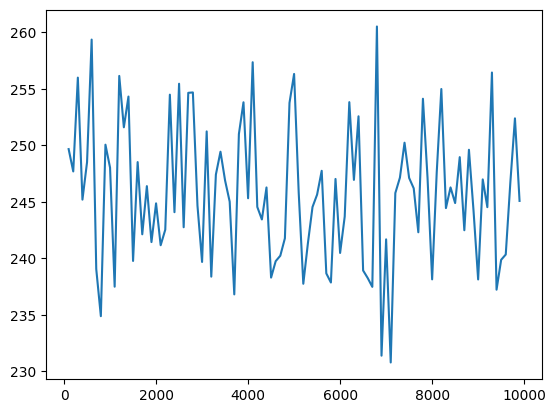

In [136]:
plt.plot(range(100, 10_000, 100), C_estime_mil)
plt.show()

In [137]:
N = 1000

In [138]:
C_estime_mil, conf_mc_mil = zip(*[C_mc_mil(n=i) for i in tqdm(range(1000, 5000, 10))])
C_estime, conf_mc = zip(*[C_mc(n=i) for i in tqdm(range(1000, 5000, 10))])

100%|██████████| 400/400 [00:03<00:00, 109.36it/s]


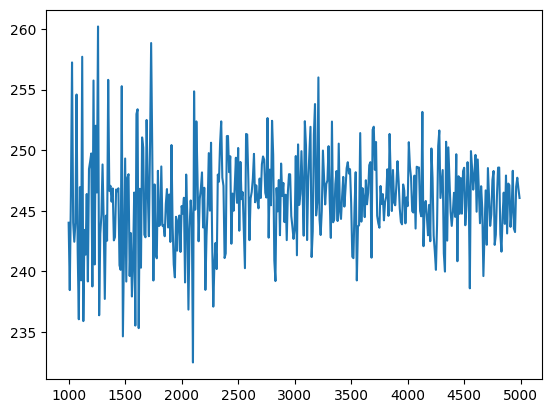

In [139]:
plt.plot(range(1000, 5000, 10), C_estime)
plt.show()

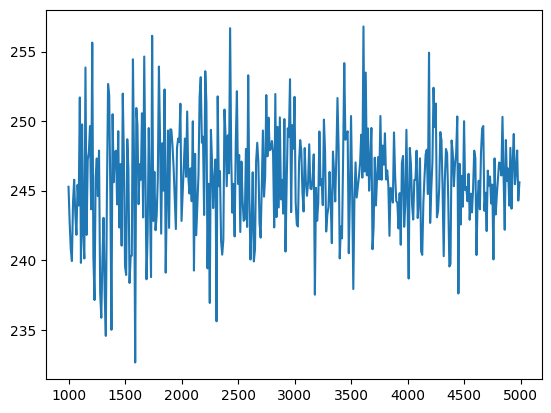

In [140]:
plt.plot(range(1000, 5000, 10), C_estime_mil)
plt.show()

In [141]:
C_estime_mil_N, conf_mc_mil_N = zip(*Parallel(n_jobs=-1)(
    delayed(C_mc_mil)(10_000, 1000, 800, 1000, 0.05, 0.2, 0.1, 1) for _ in tqdm(range(50))
))

C_estime_N, conf_mc_N = zip(*Parallel(n_jobs=-1)(
    delayed(C_mc)(10_000, 1000, 800, 1000, 0.05, 0.2, 0.1, 1) for _ in tqdm(range(50))
))

  0%|          | 0/50 [00:00<?, ?it/s]

In [142]:
print(f"Pour le schema de Milstein : Var = {np.var(C_estime_mil_N)}, Largeur IC = {np.mean(conf_mc_mil_N)}\n", f"Pour EM : Var = {np.var(C_estime_N)}, Largeur IC = {np.mean(conf_mc_N)}")

Pour le schema de Milstein : Var = 37.433427900902174, Largeur IC = 24.964363860337368
 Pour EM : Var = 36.678332252665285, Largeur IC = 24.991909243658018


In [143]:
C_estime_mil, conf_mc_mil = zip(*[C_mc_mil(N=1000, n=5000) for _ in tqdm(range(50))])
C_estime, conf_mc = zip(*[C_mc(N=1000, n=5000) for _ in tqdm(range(50))])

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:07<00:00,  7.09it/s]


In [144]:
print(f"Pour le schema de Milstein : Var = {np.var(C_estime_mil)}, Largeur IC = {np.mean(conf_mc_mil)}\n", f"Pour EM : Var = {np.var(C_estime)}, Largeur IC = {np.mean(conf_mc)}")

Pour le schema de Milstein : Var = 8.080351781127906, Largeur IC = 11.16250040769362
 Pour EM : Var = 5.557351313968958, Largeur IC = 11.141136203488053


On divise la variance par quasiment 4 dans les deux cas donc le paramètre qui influence le plus l'estimation semble être le nombre de simulation plus que la précision du schéma employé.

In [145]:
def BS_Call(S_0=S_0, K=K, r=r, sigma=sigma, T=T):
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    return S_0 * stat.norm.cdf(d1) - K * np.exp(-r * T) * stat.norm.cdf(d2)

In [146]:
print(f"EM = {C_mc(N=1000, n=5000)[0]} \n Mil = {C_mc_mil(N=1000, n=5000)[0]} \n BS = {BS_Call()}")

EM = 246.61195073632865 
 Mil = 243.76468683239872 
 BS = 245.88835443927746


\begin{align*}
dS_t = S_t(r dt + \sigma dW_t) ~~~\Longrightarrow ~~~ \frac{dS_t}{S_t} = rdt+\sigma dW_t ~~~\Longrightarrow~~~ d\ln{S_t} = \left(r-\frac{\sigma^2}{2}\right)dt+\sigma dW_t
\end{align*}

Ce qui peut se résoudre à la main avec :

\begin{equation*}
S_t = \ln{(S_0)} e^{\left( r-\frac{\sigma^2}{2} \right)t + \sigma W_t}
\end{equation*}

In [147]:
def PDD(n, N, S_0, S_a, T, r, sigma):

    h = T/N
    X = np.full(n, np.log(S_0))
    Z = np.random.normal(0, 1, (n, N))
    j0 = int(np.ceil(N/2))
    over = np.zeros(n)

    for i in range(N):
        if i >= j0:
            over += (np.exp(X) > S_a)
        X = X + (r - sigma**2 /2) * h + sigma * np.sqrt(h) * Z[:, i]


    indic = (over == 0)

    S = np.exp(X)
    
    f_S = np.exp(-r * T) * (S_a - S) * (S <= 0.8 * S_a) * indic

    return np.mean(f_S), 2 * 1.96 * np.std(f_S)/np.sqrt(n)

In [148]:
df1 = pd.DataFrame({
    'n': np.arange(1000, 100_001, 2_500),
    'Estimation': [PDD(i, 200, 100, 120, 1, 0.03, 0.45)[0] for i in tqdm(range(1000, 100_001, 2_500))]
})

100%|██████████| 40/40 [00:18<00:00,  2.18it/s]


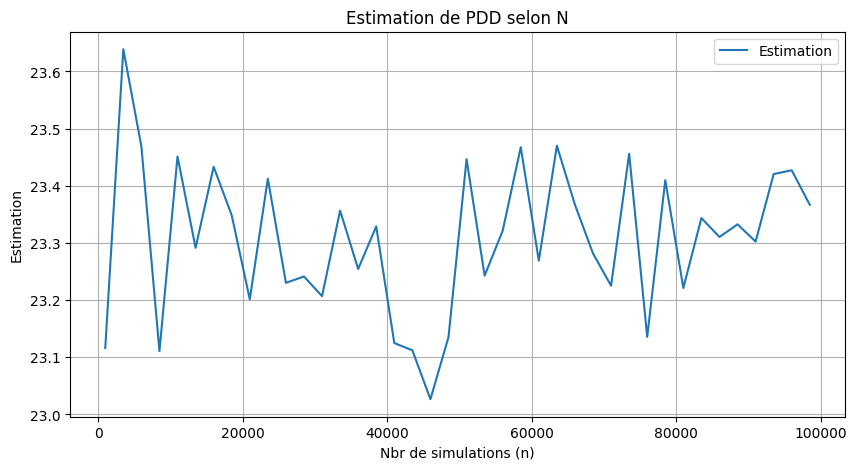

In [149]:
df1.plot(x='n', figsize=(10, 5), title="Estimation de PDD selon N")
plt.xlabel("Nbr de simulations (n)")
plt.ylabel("Estimation")
plt.grid(True)
plt.show()

In [150]:
estime_200, _ = zip(*Parallel(n_jobs=-1)(delayed(PDD)(i, 200, 100, 120, 1, 0.03, 0.45) for i in tqdm(range(1000, 100_001, 10_000))))

estime_1000, _ = zip(*Parallel(n_jobs=-1)(delayed(PDD)(i, 1000, 100, 120, 1, 0.03, 0.45) for i in tqdm(range(1000, 100_001, 10_000))))

100%|██████████| 10/10 [00:00<00:00, 8166.48it/s]


In [151]:
df2 = pd.DataFrame({
    'n': np.arange(1000, 100_001, 10_000),
    'Estimation N = 200': estime_200,
    'Estimation N = 1 000': estime_1000
})

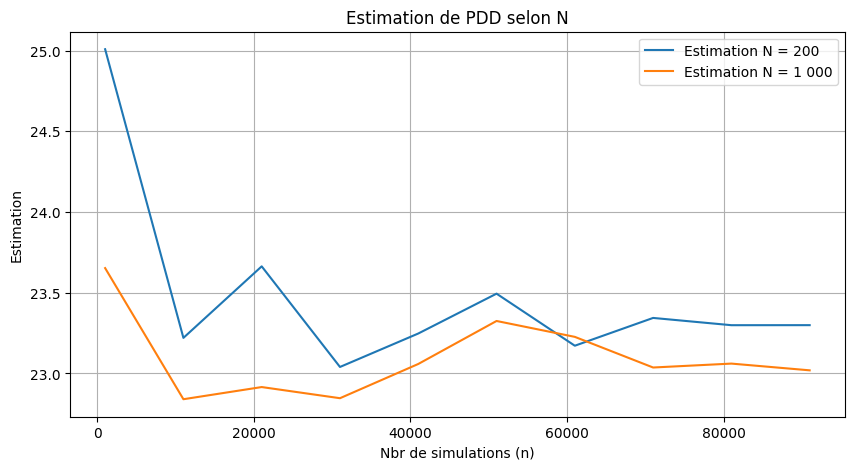

In [152]:
df2.plot(x='n', figsize=(10, 5), title="Estimation de PDD selon N")
plt.xlabel("Nbr de simulations (n)")
plt.ylabel("Estimation")
plt.grid(True)
plt.show()

In [153]:
estime_1, IC_1 = zip(*[PDD(1000, 200, 100, 120, 1, 0.03, 0.45) for _ in tqdm(range(250))])
estime_2, IC_2 = zip(*[PDD(1000, 1000, 100, 120, 1, 0.03, 0.45) for _ in tqdm(range(250))])

100%|██████████| 250/250 [00:09<00:00, 26.39it/s]


In [154]:
print(f"N = 200 -- Moyenne IC : {np.mean(IC_1)} Variance PDD : {np.var(estime_1)} \nN = 1 000 -- Moyenne IC : {np.mean(IC_2)} Variance PDD : {np.var(estime_2)}")

N = 200 -- Moyenne IC : 3.4814743649267537 Variance PDD : 0.8129520137683289 
N = 1 000 -- Moyenne IC : 3.4778257952139353 Variance PDD : 0.7640837737749157


On constate donc que la variance de l'estimation ainsi que la taille de l'intervalle de confiance ne changent pas énormément selon que l'on prenne un pas de temps de 200 ou 1000.

In [155]:
def PDD_ponts(n, N, S_0, S_a, T, r, sigma):

    h = T/N
    X = np.full(n, np.log(S_0))
    Z = np.random.normal(0, 1, (n, N))
    U = np.random.uniform(0, 1, (n, N))
    j0 = int(np.ceil(N/2))
    L = np.log(S_a)
    over = np.zeros(n)

    for i in range(N):
        if i >= j0:
            p_k = np.exp(-2 * (Y - L) * (X - L) / (sigma**2 * h))
            over += (U[:, i] <= p_k)
        Y = X
        X = X + (r - sigma**2 /2) * h + sigma * np.sqrt(h) * Z[:, i]

    indic = (over == 0)

    S = np.exp(X)
    
    f_S = np.exp(-r * T) * (S_a - S) * (S <= 0.8 * S_a) * indic

    return np.mean(f_S), 2 * 1.96 * np.std(f_S)/np.sqrt(n)

In [169]:
estime, IC = zip(*Parallel(n_jobs=-1)(delayed(PDD)(i, 200, 100, 120, 1, 0.03, 0.45) for i in tqdm(range(100, 10_000, 10))))
estime_ponts, IC_ponts = zip(*Parallel(n_jobs=-1)(delayed(PDD_ponts)(i, 200, 100, 120, 1, 0.03, 0.45) for i in tqdm(range(100, 10_000, 10))))

100%|██████████| 990/990 [00:17<00:00, 57.63it/s]


In [170]:
df = pd.DataFrame({
    "n": range(100, 10_000, 10),
    "Estime": estime,
    "Estime Ponts": estime_ponts
})

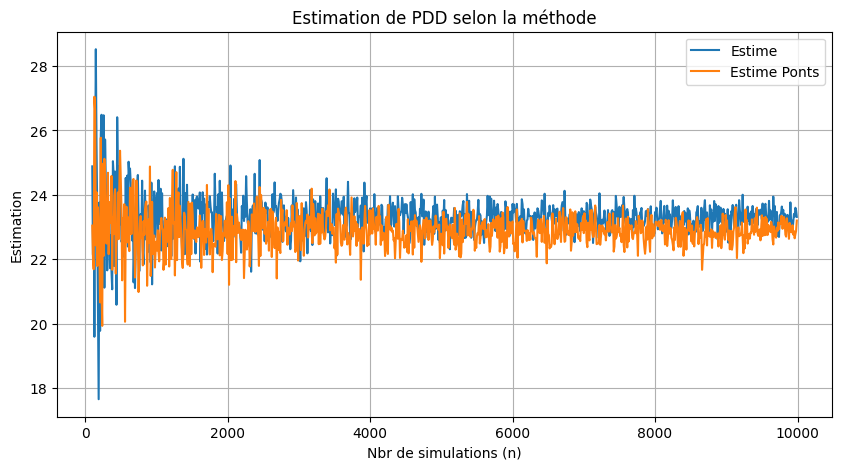

In [171]:
df.plot(x='n', figsize=(10, 5), title="Estimation de PDD selon la méthode")
plt.xlabel("Nbr de simulations (n)")
plt.ylabel("Estimation")
plt.grid(True)
plt.show()

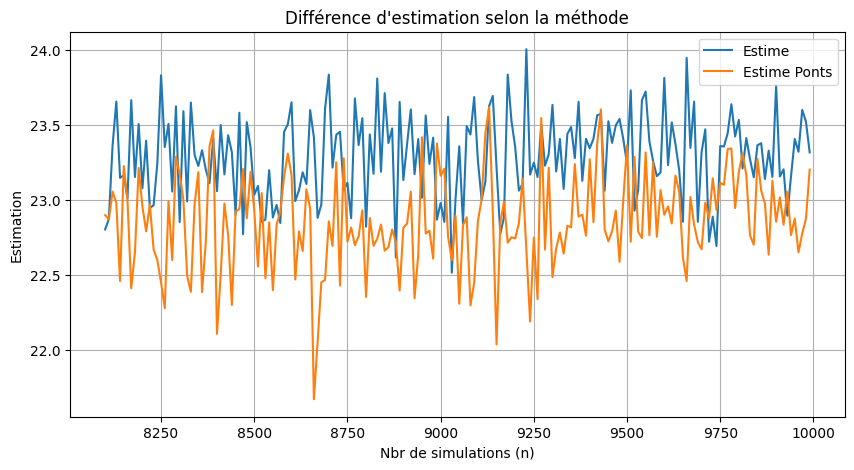

In [173]:
pd.DataFrame({
    "n": range(100, 10_000, 10)[800:],
    "Estime": estime[800:],
    "Estime Ponts": estime_ponts[800:]
}).plot(x='n', figsize=(10, 5), title="Différence d'estimation selon la méthode")
plt.xlabel("Nbr de simulations (n)")
plt.ylabel("Estimation")
plt.grid(True)
plt.show()

In [174]:
estime, IC = zip(*Parallel(n_jobs=-1)(
delayed(PDD)(i, 200, 100, 120, 1, 0.03, 0.45) for i in tqdm(range(1000, 100_000, 1000))
))
estime_ponts, IC_ponts = zip(*Parallel(n_jobs=-1)(
delayed(PDD_ponts)(i, 200, 100, 120, 1, 0.03, 0.45) for i in tqdm(range(1000, 100_000, 1000))
))

100%|██████████| 99/99 [00:20<00:00,  4.75it/s]


In [175]:
df = pd.DataFrame({
    "n": range(1000, 100_000, 1000),
    "Estime": estime,
    "Estime Ponts": estime_ponts
})

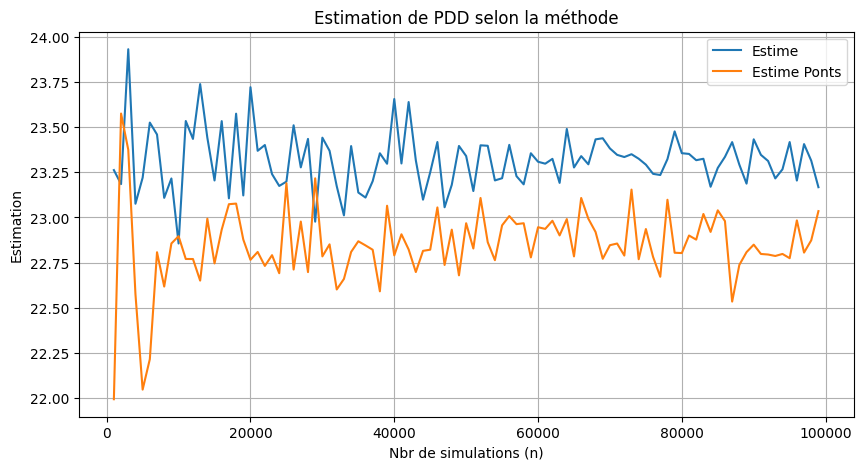

In [176]:
df.plot(x='n', figsize=(10, 5), title="Estimation de PDD selon la méthode")
plt.xlabel("Nbr de simulations (n)")
plt.ylabel("Estimation")
plt.grid(True)
plt.show()

On voit qu'avec le raffinement brownien on est systématiquement en dessous de la méthode sans raffinement (cela semble s'accentuer lorsque le nombre de simulations est grand).

In [177]:
def simCholesky(n, rho):
    Sigma = np.array([[1, rho], [rho, 1]])
    return np.random.multivariate_normal(np.zeros(2), Sigma, n)

In [178]:
def PDD_2(n, N, S_0, S_a, T, r, sigma, rho):
    S_0, S_a, r, sigma = np.array(S_0), np.array(S_a), np.array(r), np.array(sigma)
    h = T/N

    X = np.zeros((n, 2))
    X[:, 0] = np.log(S_0[0])
    X[:, 1] = np.log(S_0[1])
    Z = simCholesky((n, N), rho)
    j0 = int(np.ceil(N/2))
    over = np.zeros((n, 2))

    for i in range(N):
        X = X + (r - sigma**2 /2) * h + sigma * np.sqrt(h) * Z[:, i, :]
        if i >= j0:
            over += (np.exp(X) > S_a)
    S = np.exp(X)
    indic = (over == 0)

    f_S = np.exp(-r * T) * (S_a - S) * (S <= 0.8 * S_a) * indic

    return np.mean(f_S, axis = 0)

In [179]:
n_values = list(range(1000, 10001, 100))
PDD_1_list, PDD_2_list = zip(*[PDD_2(n, 200, [100, 110], [120, 120], 1, [0.03, 0.03], [0.45, 0.45], 0.3) for n in tqdm(n_values)])

100%|██████████| 91/91 [00:15<00:00,  6.06it/s]


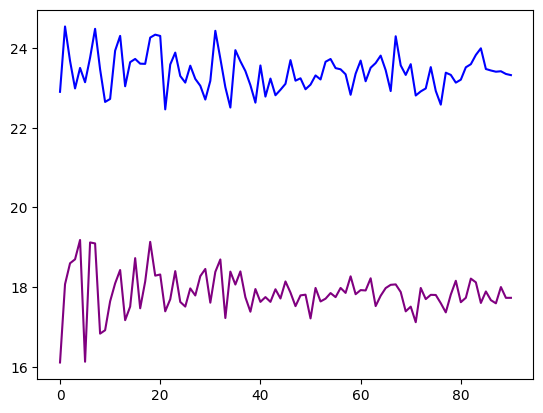

In [180]:
plt.plot(PDD_1_list, color="blue")
plt.plot(PDD_2_list, color="purple")
plt.show()

In [181]:
def PDD_2_ponts(n, N, S_0, S_a, T, r, sigma, rho):
    S_0, S_a, r, sigma = np.array(S_0), np.array(S_a), np.array(r), np.array(sigma)
    h = T/N

    X = np.zeros((n, 2))
    X[:, 0] = np.log(S_0[0])
    X[:, 1] = np.log(S_0[1])
    Z = simCholesky((n, N), rho)
    j0 = int(np.ceil(N/2))
    over = np.zeros((n, 2))
    Y = np.zeros((n, 2))
    U = np.random.uniform(0, 1, (n, N, 2))
    L = np.log(S_a)

    for i in range(N):
        Y = X
        X = X + (r - sigma**2 /2) * h + sigma * np.sqrt(h) * Z[:, i, :]
        if i >= j0:
            p_k = np.exp(-2 * (Y - L) * (X - L) / (sigma**2 * h))
            over += (U[:, i, :] <= p_k )
    S = np.exp(X)
    indic = (over == 0)

    f_S = np.exp(-r * T) * (S_a - S) * (S <= 0.8 * S_a) * indic

    return np.mean(f_S, axis = 0)

In [189]:
n_values = list(range(1000, 100_001, 1000))
PDD_1_list, PDD_2_list = zip(*Parallel(n_jobs=-1)(
    delayed(PDD_2)(n, 200, [100, 110], [120, 120], 1, [0.03, 0.03], [0.45, 0.45], 0.3) 
    for n in tqdm(n_values)
))

PDD_1_ponts_list, PDD_2_ponts_list = zip(*Parallel(n_jobs=-1)(
    delayed(PDD_2_ponts)(n, 200, [100, 110], [120, 120], 1, [0.03, 0.03], [0.45, 0.45], 0.3) 
    for n in tqdm(n_values)
))

100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


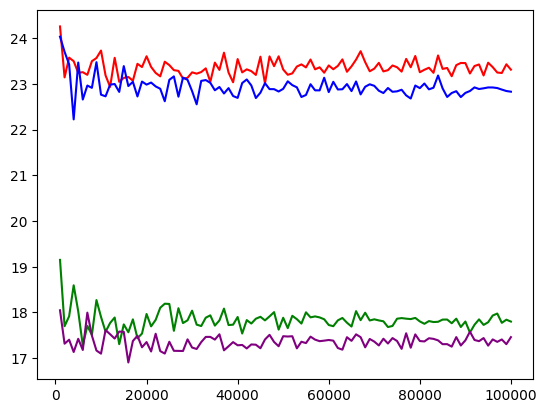

In [190]:
plt.plot(n_values, PDD_1_list, color="red")
plt.plot(n_values, PDD_2_list, color="green")
plt.plot(n_values, PDD_1_ponts_list, color="blue")
plt.plot(n_values, PDD_2_ponts_list, color="purple")
plt.show()

rho=-0.8: 100%|██████████| 91/91 [00:02<00:00, 36.82it/s]


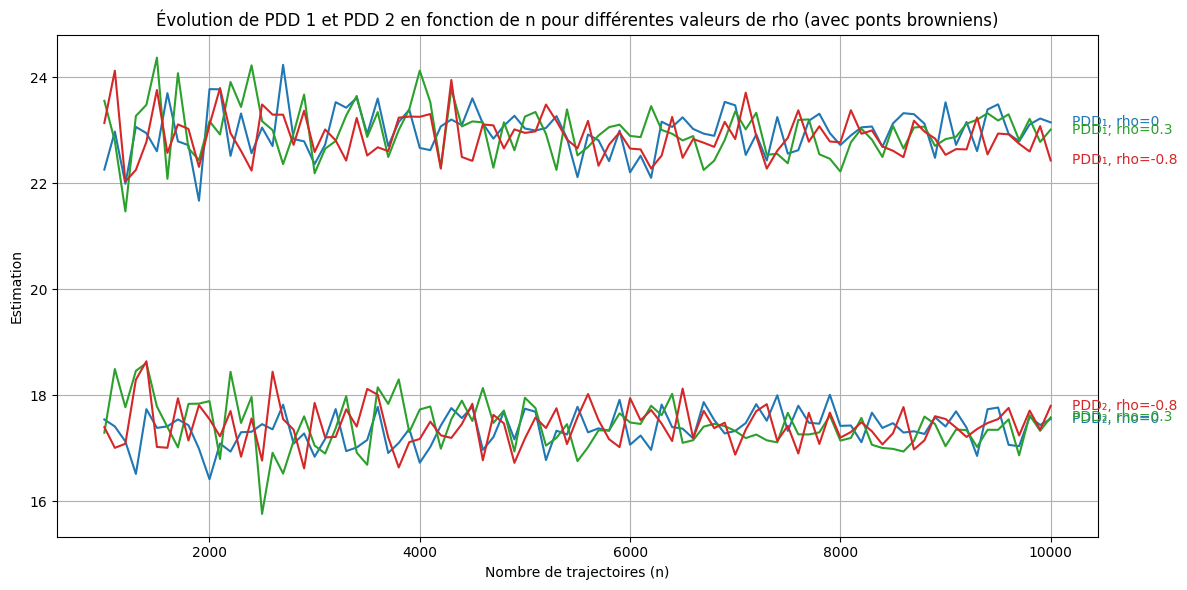

In [184]:
colors = {0: 'tab:blue', 0.3: 'tab:green', -0.8: 'tab:red'}
n_values = list(range(1000, 10001, 100))

plt.figure(figsize=(12, 6))

for rho in colors.keys():
    color = colors[rho]

    results = Parallel(n_jobs=-1)(
        delayed(lambda n: PDD_2_ponts(n, 200, [100, 110], [120, 120], 1, [0.03, 0.03], [0.45, 0.45], rho))(n)
        for n in tqdm(n_values, desc=f"rho={rho}")
    )

    PDD_1_ponts_list, PDD_2_ponts_list = zip(*results)

    plt.plot(n_values, PDD_1_ponts_list, color=color)
    plt.plot(n_values, PDD_2_ponts_list, color=color)
    plt.text(n_values[-1] + 200, PDD_1_ponts_list[-1], f'PDD₁, rho={rho}', color=color, va='center')
    plt.text(n_values[-1] + 200, PDD_2_ponts_list[-1], f'PDD₂, rho={rho}', color=color, va='center')

plt.title("Évolution de PDD 1 et PDD 2 en fonction de n pour différentes valeurs de rho (avec ponts browniens)")
plt.xlabel("Nombre de trajectoires (n)")
plt.ylabel("Estimation")
plt.grid(True)
plt.tight_layout()
plt.show()